# KOH Posterior Analysis using Mici

This notebook looks at the different ways to implement an MCMC algorithm using Gaussian random-walk Metropolis proposal under the Mici framework.

The goal is to discover the best set-up and compare results against the MATLAB code previously implemented.

First, import the required packages and set up the KOH and Mici frameworks.

In [1]:
from matlabmodel import neg_log_dens
from mappings import mapRto01, map01toR, mapRto0inf, map0inftoR, ell2rho, beta2ell
from jax import jit

import numpy as np
import mici

import matplotlib.pyplot as plt

import arviz

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [2]:
seed = 1234
n_chain = 1
n_dim = 7
n_warm_up_iter = 4000
n_main_iter = 10000
rng = np.random.default_rng(seed)

init_states = np.array([[
    map01toR(0.4257), 
    map0inftoR(beta2ell(51.5551)), #these are the beta values!!!
    map0inftoR(beta2ell(3.5455)), 
    # map0inftoR(beta2ell(2)), 
    map0inftoR(0.25557), 
    map0inftoR(37.0552), 
    map0inftoR(10030.5142), 
    map0inftoR(79548.2126)
]])

tmax = 0.6
tmin = 0.2


##### KOH Model #####
jitted_neg_log_posterior_density = jit(neg_log_dens)


##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=jitted_neg_log_posterior_density,
    grad_neg_log_dens=lambda q: q * 0,
)
integrator = mici.integrators.LeapfrogIntegrator(system)

## Setup 1

Adapters:
- DualAveragingStepSizeAdapter(0.234)
- OnlineCovarianceMetricAdapter()

Results:
- Fails to achieve the target acceptance rate of 0.234, instead achieves around 0.2
- ESS bulk values are very similar for each variable.
- Parameter estimate for $\theta$ is very good. 
- 

In [3]:
##### Mici sampler and adapters #####
sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=1)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.234),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, n_main_iter, init_states, adapters=adapters, n_process=n_chain
)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Sampling stage: Initial fast adaptive [00:00] > Slow adaptive (1/7) [00:00] > Slow adaptive (2/7) [00:00] > Slow adaptive (3/7) [00:00] > Slow adaptive (4/7) [00:00] > Slow adaptive (5/7) [00:01] > Slow adaptive (6/7) [00:02] > Slow adaptive (7/7) [00:07] > Final fast adaptive [00:00] > Main non-adaptive [00:33]

Chain 1/1: 100%|██████████|10000/10000 [00:33<00:00, 295.51it/s, accept_stat=0.112]

# Analyse the Chains

In [4]:
arviz.summary(traces)#, var_names=["σ", "ϵ", "γ", "β", "x_0"])

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pos[0],-0.258,0.146,-0.520,0.011,0.008,0.006,352.0,438.0,NaN
pos[1],-2.332,0.031,-2.383,-2.271,0.002,0.001,303.0,469.0,NaN
pos[2],-0.957,0.056,-1.064,-0.860,0.003,0.002,317.0,425.0,NaN
pos[3],-1.349,0.207,-1.714,-0.959,0.011,0.008,345.0,396.0,NaN
pos[4],3.504,0.283,2.977,4.024,0.016,0.011,319.0,477.0,NaN
pos[5],9.048,0.343,8.435,9.675,0.023,0.016,224.0,302.0,NaN
pos[6],11.263,0.117,11.031,11.472,0.007,0.005,313.0,534.0,NaN
hamiltonian,-786.158,2.653,-790.589,-781.153,0.118,0.084,476.0,1117.0,NaN


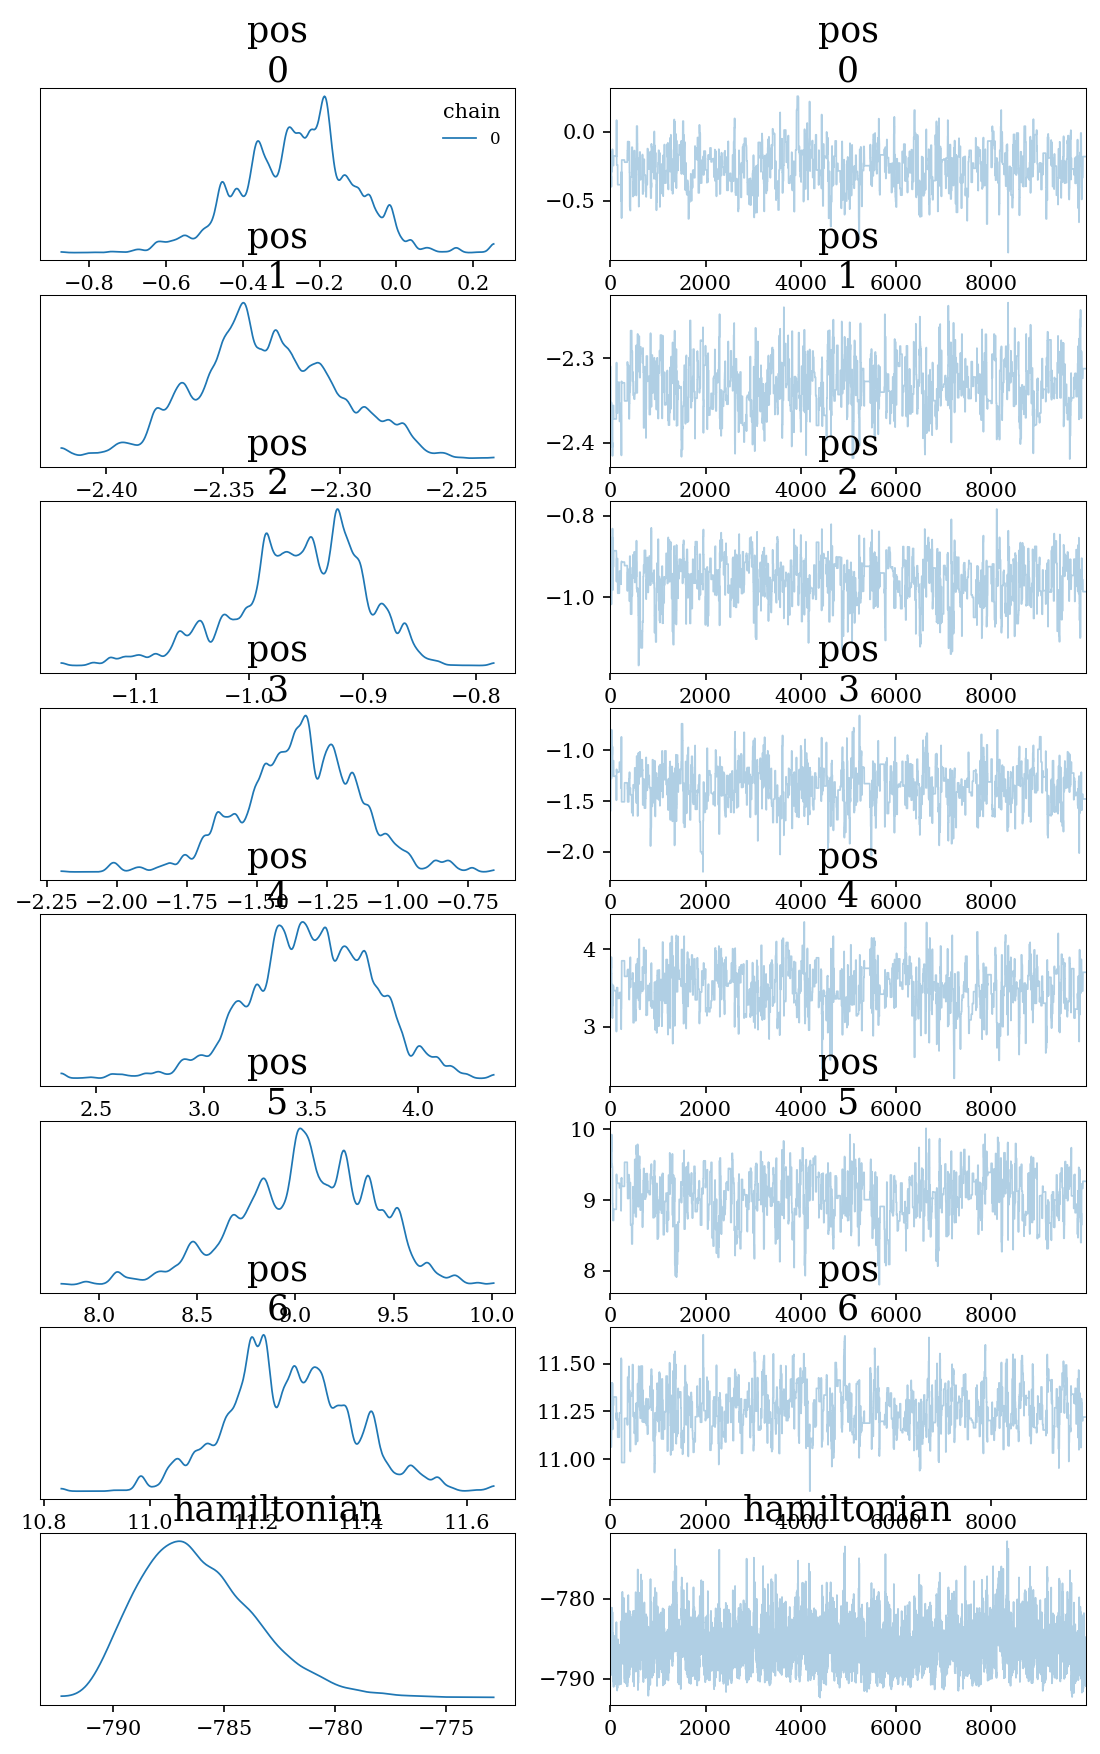

In [10]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces,
        # var_names=["σ", "ϵ", "γ", "β", "x_0"],
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )
plt.show()

# Transform the Chains

In [11]:
traces_transformed = {'pos': []}
traces_transformed['pos'].append(np.empty_like(traces['pos'][0]))
for i in range(0, 1):
    traces_transformed['pos'][0][:, i] = mapRto01(traces['pos'][0][:, i])*(tmax-tmin) + tmin
for i in range(1, 3):
    traces_transformed['pos'][0][:, i] = ell2rho(mapRto0inf(traces['pos'][0][:, i]))
for i in range(3, 7):
    traces_transformed['pos'][0][:, i] = mapRto0inf(traces['pos'][0][:, i])

for i in range(7):
    print(np.mean(traces_transformed['pos'][0][:, i]), '±', np.std(traces_transformed['pos'][0][:, i]))



0.4255414963168313 ± 0.014278702720900925
2.344494191164183e-06 ± 2.029297183198658e-06
0.42845946133094337 ± 0.04081206920841679
0.2651089024663802 ± 0.05493173948815767
34.57040044854628 ± 9.650077834397903
8998.670345608803 ± 2973.062533686023
78448.3715542844 ± 9274.704387609696


In [12]:
print(type(traces['pos'][0]))

<class 'numpy.ndarray'>


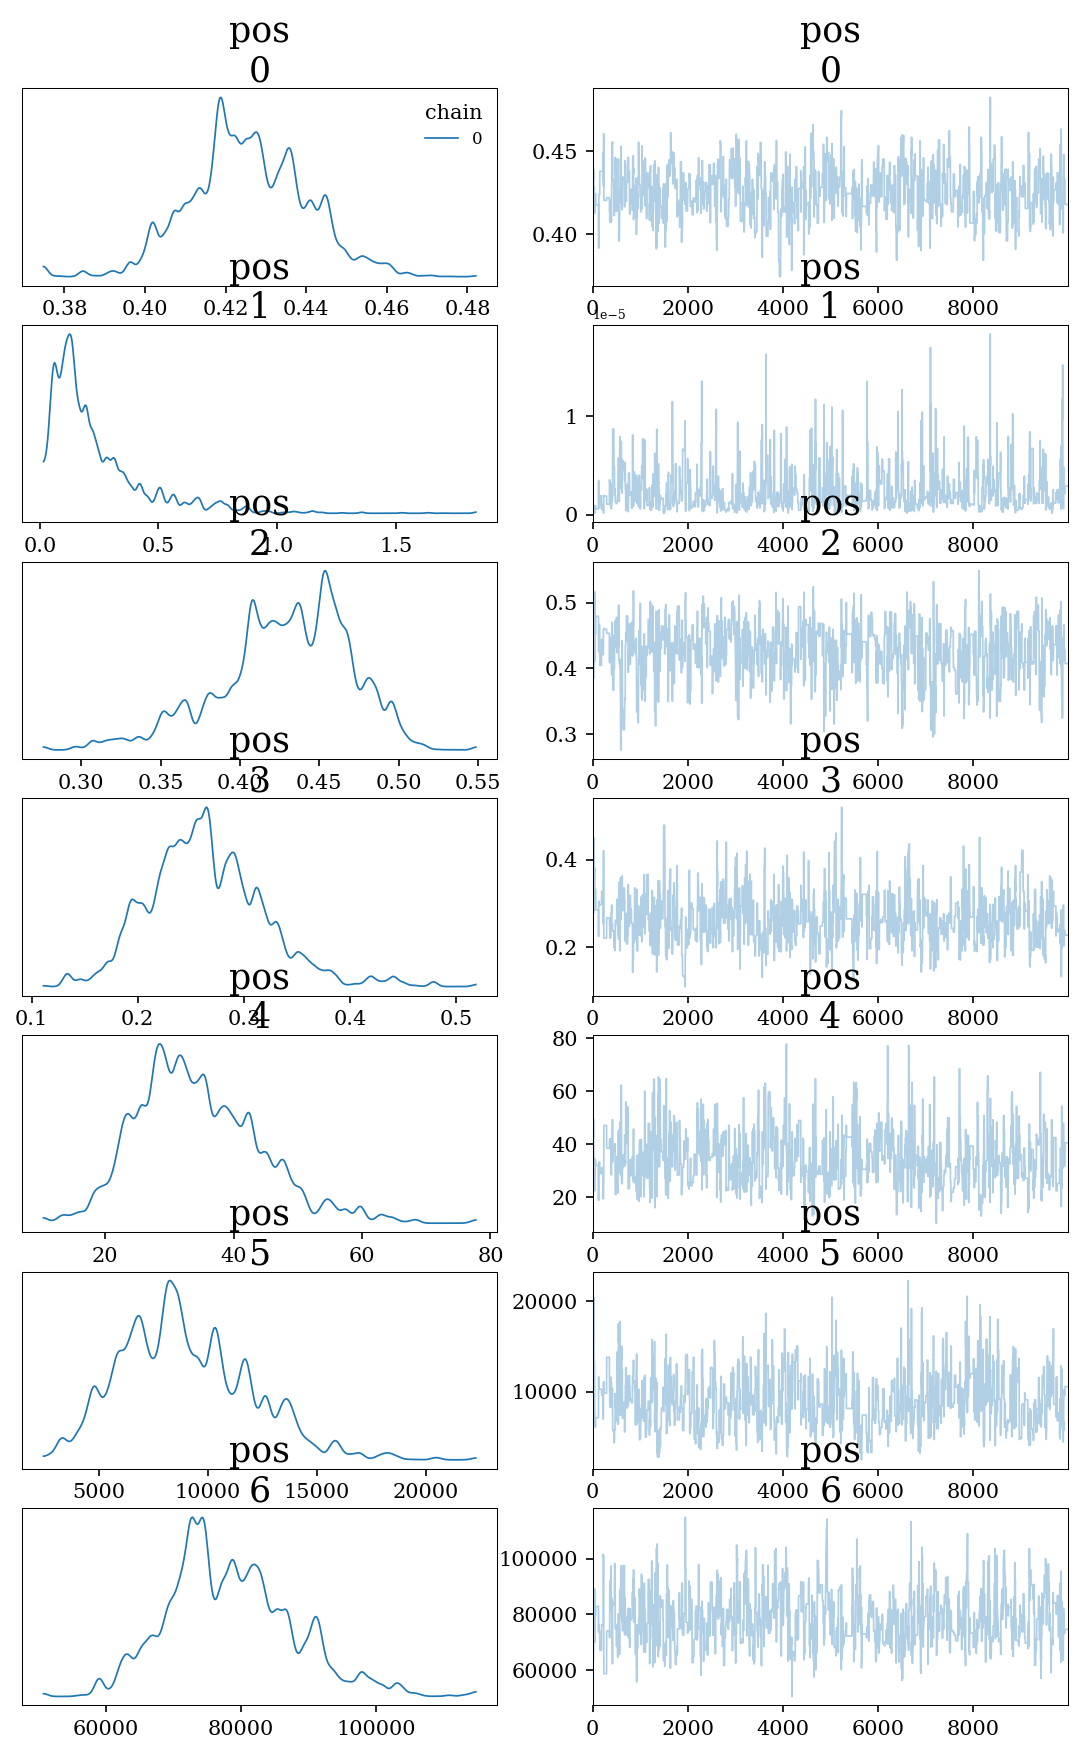

In [16]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )
plt.show()